# MAPS
**MAPS** (**M**achine learning for **A**nalysis of **P**roteomics in **S**patial biology) is a Python package and includes a cell_phenotyping module, which is specifically designed for pathologist-level cell phenotyping from multiplex images of histology tissue through machine learning.

## Cell Phenotyping
The cell_phenotyping module in MAPS provides a machine learning pipeline to train a robust cell classification model on a given dataset and to use a pretrained model to make prediction on new data. 

### Model Input
To use cell_phenotyping module, the dataset should be prepared in a CSV format with at least N+1 columns, where N is the number of markers in the given dataset, and the additional column is for cell size (header:CellSize). Each row of the CSV file should represent marker expressions for a particular cell along with its size.

To train a new cell phenotyping model, the dataset needs to be split into train and validation CSV files. Both of these files should have an additional column called 'cell_label', this column is a numeric encoding of the cell type, do not confuse this cell_label with the label of the segmentation mask.  The 'cell_label' column provides the ground truth (class ID / cell type) for each cell.

Check an example of such input table below:


In [1]:
import pandas as pd

pd.read_csv('./data/raw/ROI_01-02_raw.csv').head(5)

,cell_label,cellSize,Actin,aSMA,CD3e,CD4,CD8,CD11c,CD20,CD31,CD56,CD66b,CD68,Cytokeratin,FOXP3,HLA_DR,Iba1,Mast_Cell_Tryptase
0,5,821,75.963463,168.138855,779.632141,88.456757,1378.082886,226.873322,5.884287,262.542023,404.970764,15.018270,276.194885,58.283802,1014.059692,62.915955,914.350769,23.844093
1,14,1492,165.058304,202.401474,333.237274,110.880028,433.504028,1217.235229,30.040215,14.623324,632.682983,73.445038,295.325745,76.392090,2057.586426,73.343834,1407.994019,28.153484
2,14,729,90.787376,235.257889,568.683105,95.444443,378.304535,721.925903,9.108368,26.155006,442.851837,169.079559,252.161865,72.042526,1269.672119,69.181068,1409.728394,23.850481
3,14,2026,199.556763,227.523697,1573.749268,112.490623,2655.541992,4011.190430,52.287266,16.488647,435.236420,685.712219,333.215698,69.624878,1928.139648,70.101677,2851.223145,26.874136
4,14,1151,143.848831,241.038223,428.734131,111.934837,663.818420,2462.097412,32.255428,24.290182,786.274536,190.874893,338.561249,83.456123,1894.309326,100.551697,1944.357056,33.395309


The cell_labels above correspond to the following cell types:

In [2]:
pd.read_csv('./inputs/examples/cell_type_labels.csv')

,name,label
0,B cells,0
1,CD4+ T cells,1
2,CD8+ T cells,2
3,Cancer cells,3
4,DCs,4
5,Endothelial,5
6,Fibroblasts,6
7,Granulocytes,7
8,Macrophages,8
9,Mast cells,9


In [3]:
cell_label_df=pd.read_csv('./inputs/examples/cell_type_labels.csv')
cell_label_dict_inv={row['label']: row['name'] for key,row in cell_label_df.iterrows()}
cell_label_dict_inv

{0: 'B cells',
 1: 'CD4+ T cells',
 2: 'CD8+ T cells',
 3: 'Cancer cells',
 4: 'DCs',
 5: 'Endothelial',
 6: 'Fibroblasts',
 7: 'Granulocytes',
 8: 'Macrophages',
 9: 'Mast cells',
 10: 'NK cells',
 11: 'NKT cells',
 12: 'T cells',
 13: 'Treg',
 14: 'ungated'}

### Model Training

The cell_phenotyping module includes a Trainer class, which is designed to handle the model training process. This class comes with various configurable attributes that can be set when instantiating the class, such as the number of classes, number of features, learning rate, batch size, and the number of epochs to train the model. The **fit** method is used to train the model using the training and validation datasets and saves the best model based on the lowest validation loss. 

In [4]:
%cd ./batch_cell_typing

[WinError 2] The system cannot find the file specified: './batch_cell_typing'
c:\Users\vp232003\repos\batch_cell_typing


c:\Anaconda3\envs\maps_env\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [5]:
pwd

'c:\\Users\\vp232003\\repos\\batch_cell_typing'

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

In [10]:
data_path = Path('./data/raw/ROI_01-02_raw.csv')

data = pd.read_csv( data_path )
no_features=len(data.columns)-1
no_classes=data['cell_label'].nunique()

outdir=Path('./outputs')
print(no_features)
print(no_classes)

17
15


In [9]:
from maps.cell_phenotyping import Trainer

# Split the data into train and validation
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
data_train_path=outdir / 'examples' / 'training.csv'
data_val_path=outdir / 'examples' / 'validation.csv'

train_data.to_csv(data_train_path, index=False)
val_data.to_csv(data_val_path,index=False)
# Extract number of classes (cell types) and number of features (number of markers + cell size)

no_features=len(train_data.columns)-1
no_classes=train_data['cell_label'].nunique()#print('no_of_markers+cellSize column:',no_features)
print('no_of_cell_types:', no_classes )

model = Trainer(
            results_dir=outdir/ 'models', 
            num_features=no_features, 
            num_classes=no_classes, 
            batch_size=128, max_epochs=200,
            min_epochs=30, 
            patience=10, 
            verbose=0)
            


no_of_cell_types: 15


In [22]:
model.fit(data_train_path, data_val_path)

Train Epoch: 0, train_loss: 1.4674, train_acc: 0.4785, train_auc: 0.9064                 
Valid Epoch: 0, valid_loss: 0.8906, valid_acc: 0.7164, valid_auc: 0.9627                 
--------------------Saving best model--------------------
Time to process epoch(0): 0.5399 minutes                             

Train Epoch: 1, train_loss: 0.7592, train_acc: 0.7339, train_auc: 0.9691                 
Valid Epoch: 1, valid_loss: 0.5064, valid_acc: 0.8493, valid_auc: 0.9813                 
--------------------Saving best model--------------------
Time to process epoch(1): 0.5399 minutes                             

Train Epoch: 2, train_loss: 0.5396, train_acc: 0.8142, train_auc: 0.9825                 
Valid Epoch: 2, valid_loss: 0.4377, valid_acc: 0.8635, valid_auc: 0.9873                 
--------------------Saving best model--------------------
Time to process epoch(2): 0.5464 minutes                             

Train Epoch: 3, train_loss: 0.4378, train_acc: 0.8451, train_auc: 0.9876 

### Validation of training process
During the training of a new model, the progress is monitored and saved in a CSV file which is stored in a pre-defined results directory. This file contains information about the training progress, such as the loss and accuracy values. Furthermore, the best checkpoint is saved based on the lowest validation loss during the training.

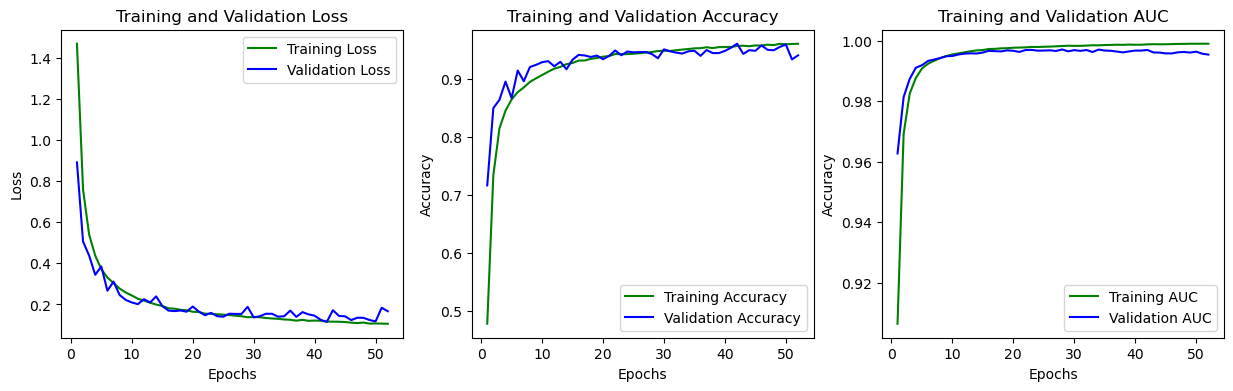

In [10]:
from tutorial import utils
utils.visulize_training_logs( './outputs/models/training_logs.csv' )

### Prediction

In [11]:
from maps.cell_phenotyping import Predictor
test_data_path=Path('./data/raw/ROI_03_raw.csv')
pretrained_model_checkpoint_path = './outputs/models/best_checkpoint.pt'
model = Predictor(model_checkpoint_path=pretrained_model_checkpoint_path, num_features=no_features, num_classes=no_classes, batch_size=128)
pred_labels, pred_probs = model.predict(test_data_path)

Batch 531/531            

In [12]:
pred_labels, pred_probs = model.predict(test_data_path)

Batch 531/531            

### Model evaluation

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [15]:
# Map the classes to the original cell_type
ground_truth =  pd.read_csv( test_data_path)['cell_label'].map(cell_label_dict_inv)
prediction = pd.Series(pred_labels).map(cell_label_dict_inv)
ground_truth=ground_truth.rename('ground_truth')
prediction=prediction.rename('prediction')

In [16]:
# Calculate the classification report
report = classification_report(ground_truth, prediction, output_dict=True)

# Convert the report to a DataFrame
df_f1_scores = pd.DataFrame(report).transpose()

# convert the index to a column
df_f1_scores.reset_index(inplace=True)

df_f1_scores

c:\Anaconda3\envs\maps_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda3\envs\maps_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda3\envs\maps_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda3\envs\maps_env\lib\site-packag

,index,precision,recall,f1-score,support
0,B cells,0.191275,0.423792,0.263584,269.000000
1,CD4+ T cells,0.482597,0.965044,0.643429,3204.000000
2,CD8+ T cells,0.000000,0.000000,0.000000,2005.000000
3,Cancer cells,0.995881,0.558019,0.715259,39866.000000
4,DCs,0.000000,0.000000,0.000000,0.000000
5,Endothelial,0.913265,0.064985,0.121335,5509.000000
6,Fibroblasts,0.659839,0.515723,0.578947,1749.000000
7,Granulocytes,0.011873,0.975806,0.023461,124.000000
8,Macrophages,0.950629,0.254338,0.401308,3861.000000
9,Mast cells,1.000000,0.437500,0.608696,32.000000


In [ ]:
#save the df_f1_scores
#df_f1_scores.to_csv('./results_maps/michelson/ROI_03_raw_maps_f1_scores.csv', index=False)

In [17]:
    df_confusion_no_margin = pd.crosstab(ground_truth, prediction)
    df_confusion_nominal = pd.crosstab(ground_truth, prediction, rownames=['Ground truth'], colnames=['Predicted'], margins=True)

    df_conf_norm = df_confusion_no_margin.div(df_confusion_no_margin.sum(axis=1), axis="index")
    
    cm={
        'nominal': df_confusion_nominal,
        'normal': df_conf_norm
    }

# Confusion Matrix

In [19]:
cm['nominal'].style.format(precision=2).background_gradient(cmap ='Blues')

Predicted,B cells,CD4+ T cells,Cancer cells,DCs,Endothelial,Fibroblasts,Granulocytes,Macrophages,Mast cells,NK cells,NKT cells,T cells,Treg,ungated,All
Ground truth,,,,,,,,,,,,,,,
B cells,114,98,0,0,0,0,5,8,0,0,9,0,35,0,269
CD4+ T cells,0,3092,0,0,0,0,0,0,0,0,0,105,6,1,3204
CD8+ T cells,0,11,0,0,0,0,0,0,0,0,1851,143,0,0,2005
Cancer cells,50,25,22246,5,9,51,8362,26,0,1,387,1087,1,7616,39866
Endothelial,166,116,0,137,358,279,310,3,0,0,31,42,0,4067,5509
Fibroblasts,43,133,0,0,1,902,425,2,0,0,16,14,0,213,1749
Granulocytes,0,1,0,0,0,0,121,0,0,0,1,1,0,0,124
Macrophages,49,145,37,3,1,104,564,982,0,0,26,41,0,1909,3861
Mast cells,1,0,0,0,0,1,0,0,14,0,0,0,0,16,32


# Confusion Matrix with Normalization

<Axes: xlabel='prediction', ylabel='ground_truth'>

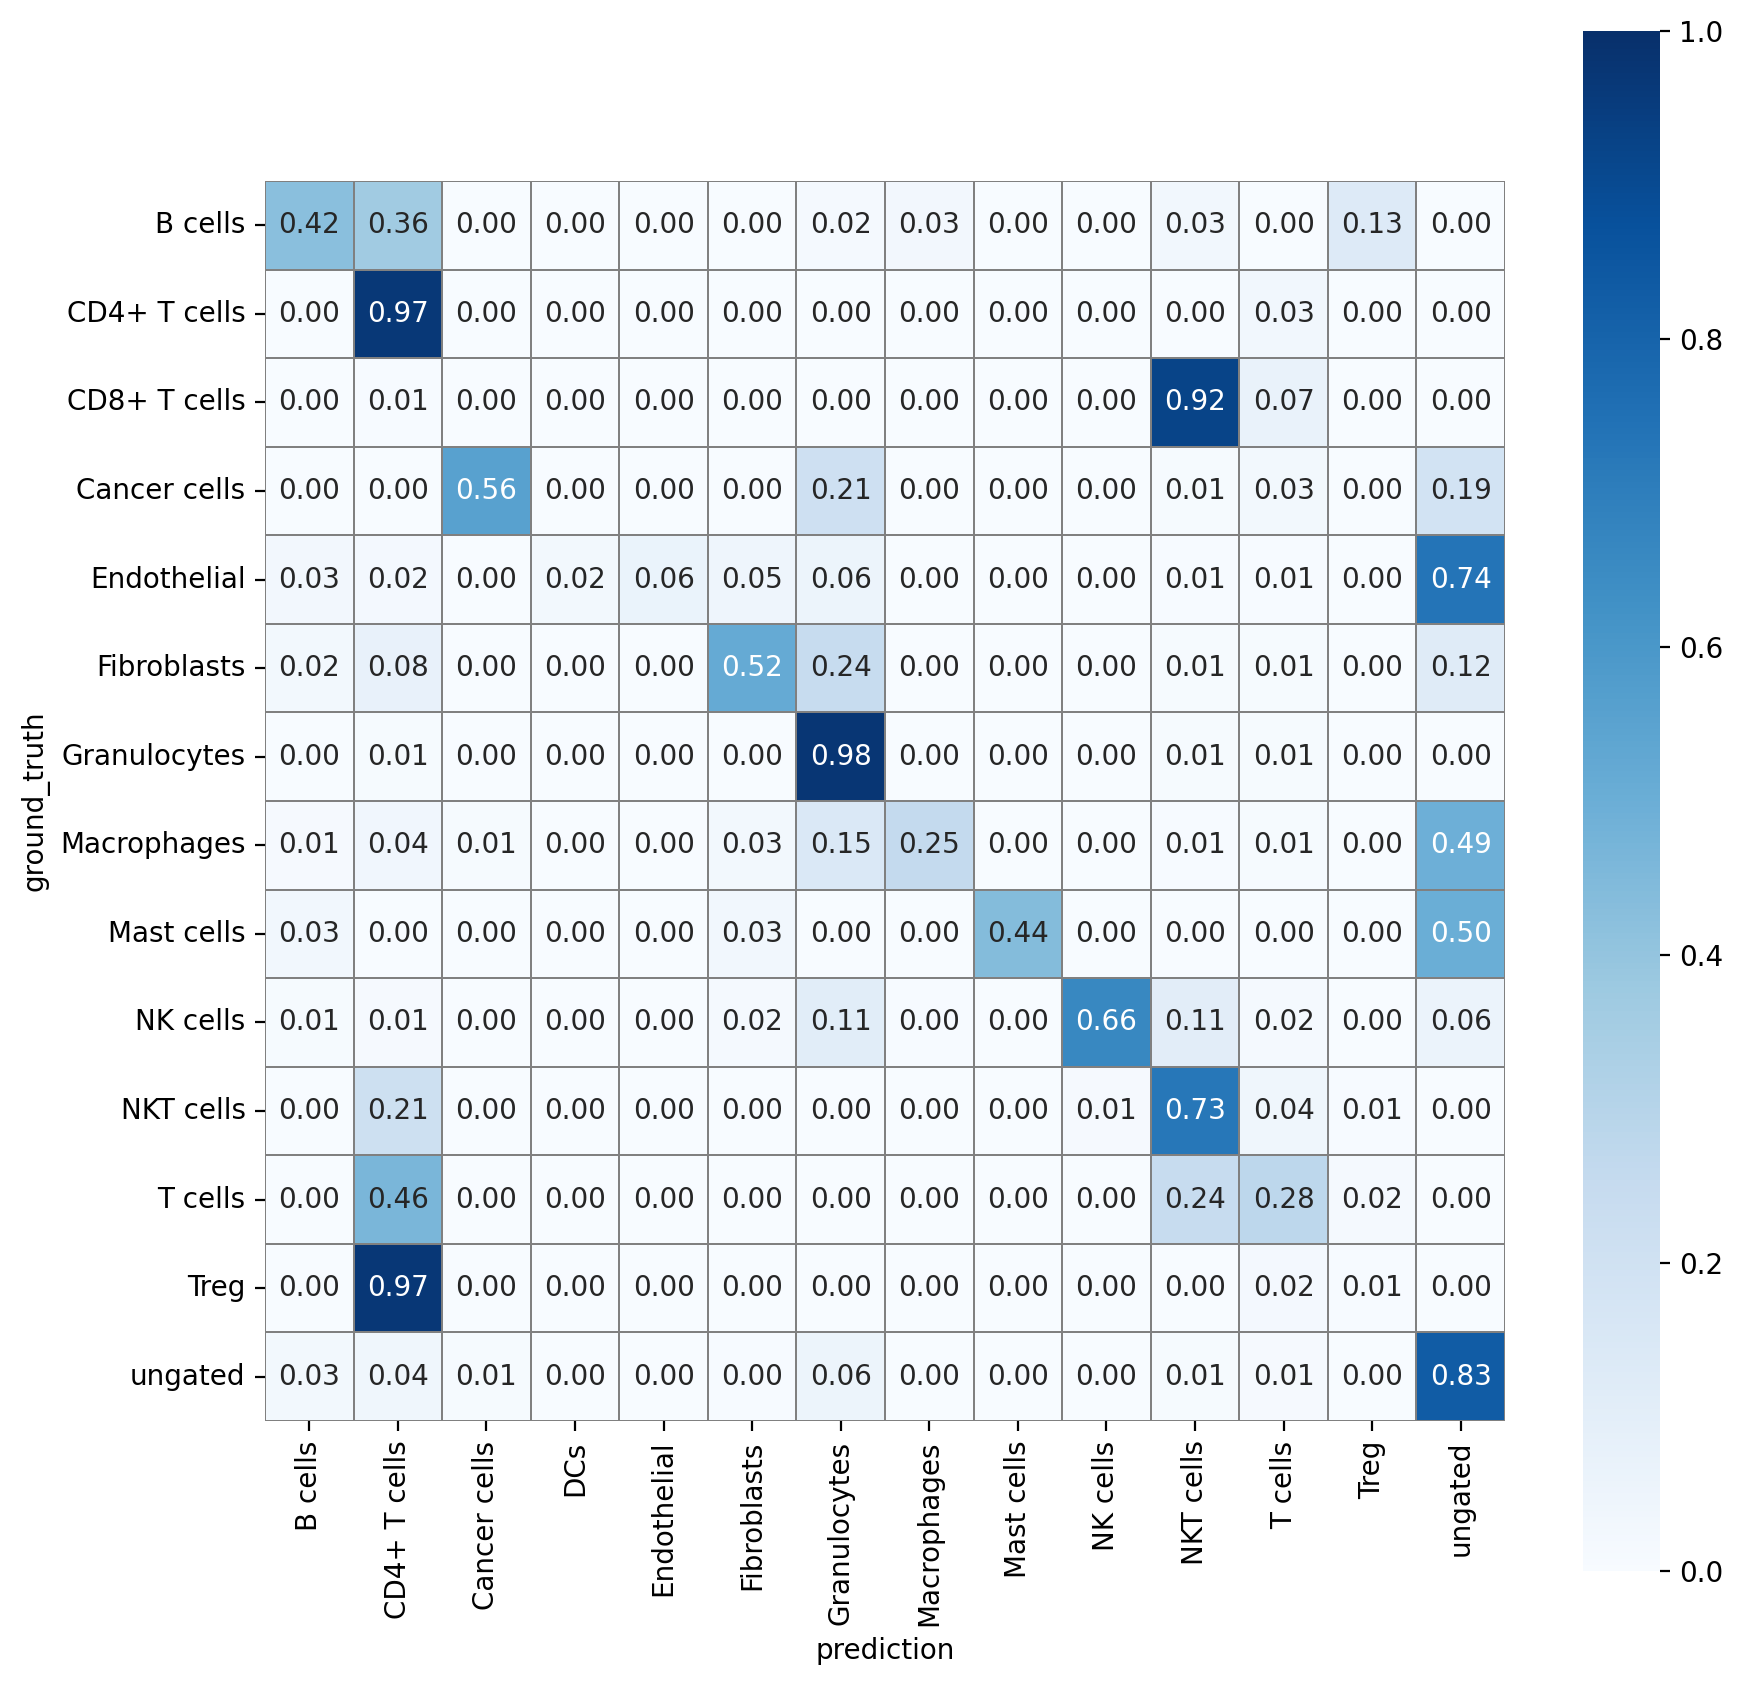

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(cm['normal'].round(decimals=2),annot=True,square=True,cmap='Blues',linecolor='grey',linewidth=0.1,ax=ax)
sns.heatmap(cm['normal'],annot=True,vmin=0,vmax=1,square=True,fmt='.2f',cmap='Blues',linecolor='grey',linewidth=0.1,ax=ax)


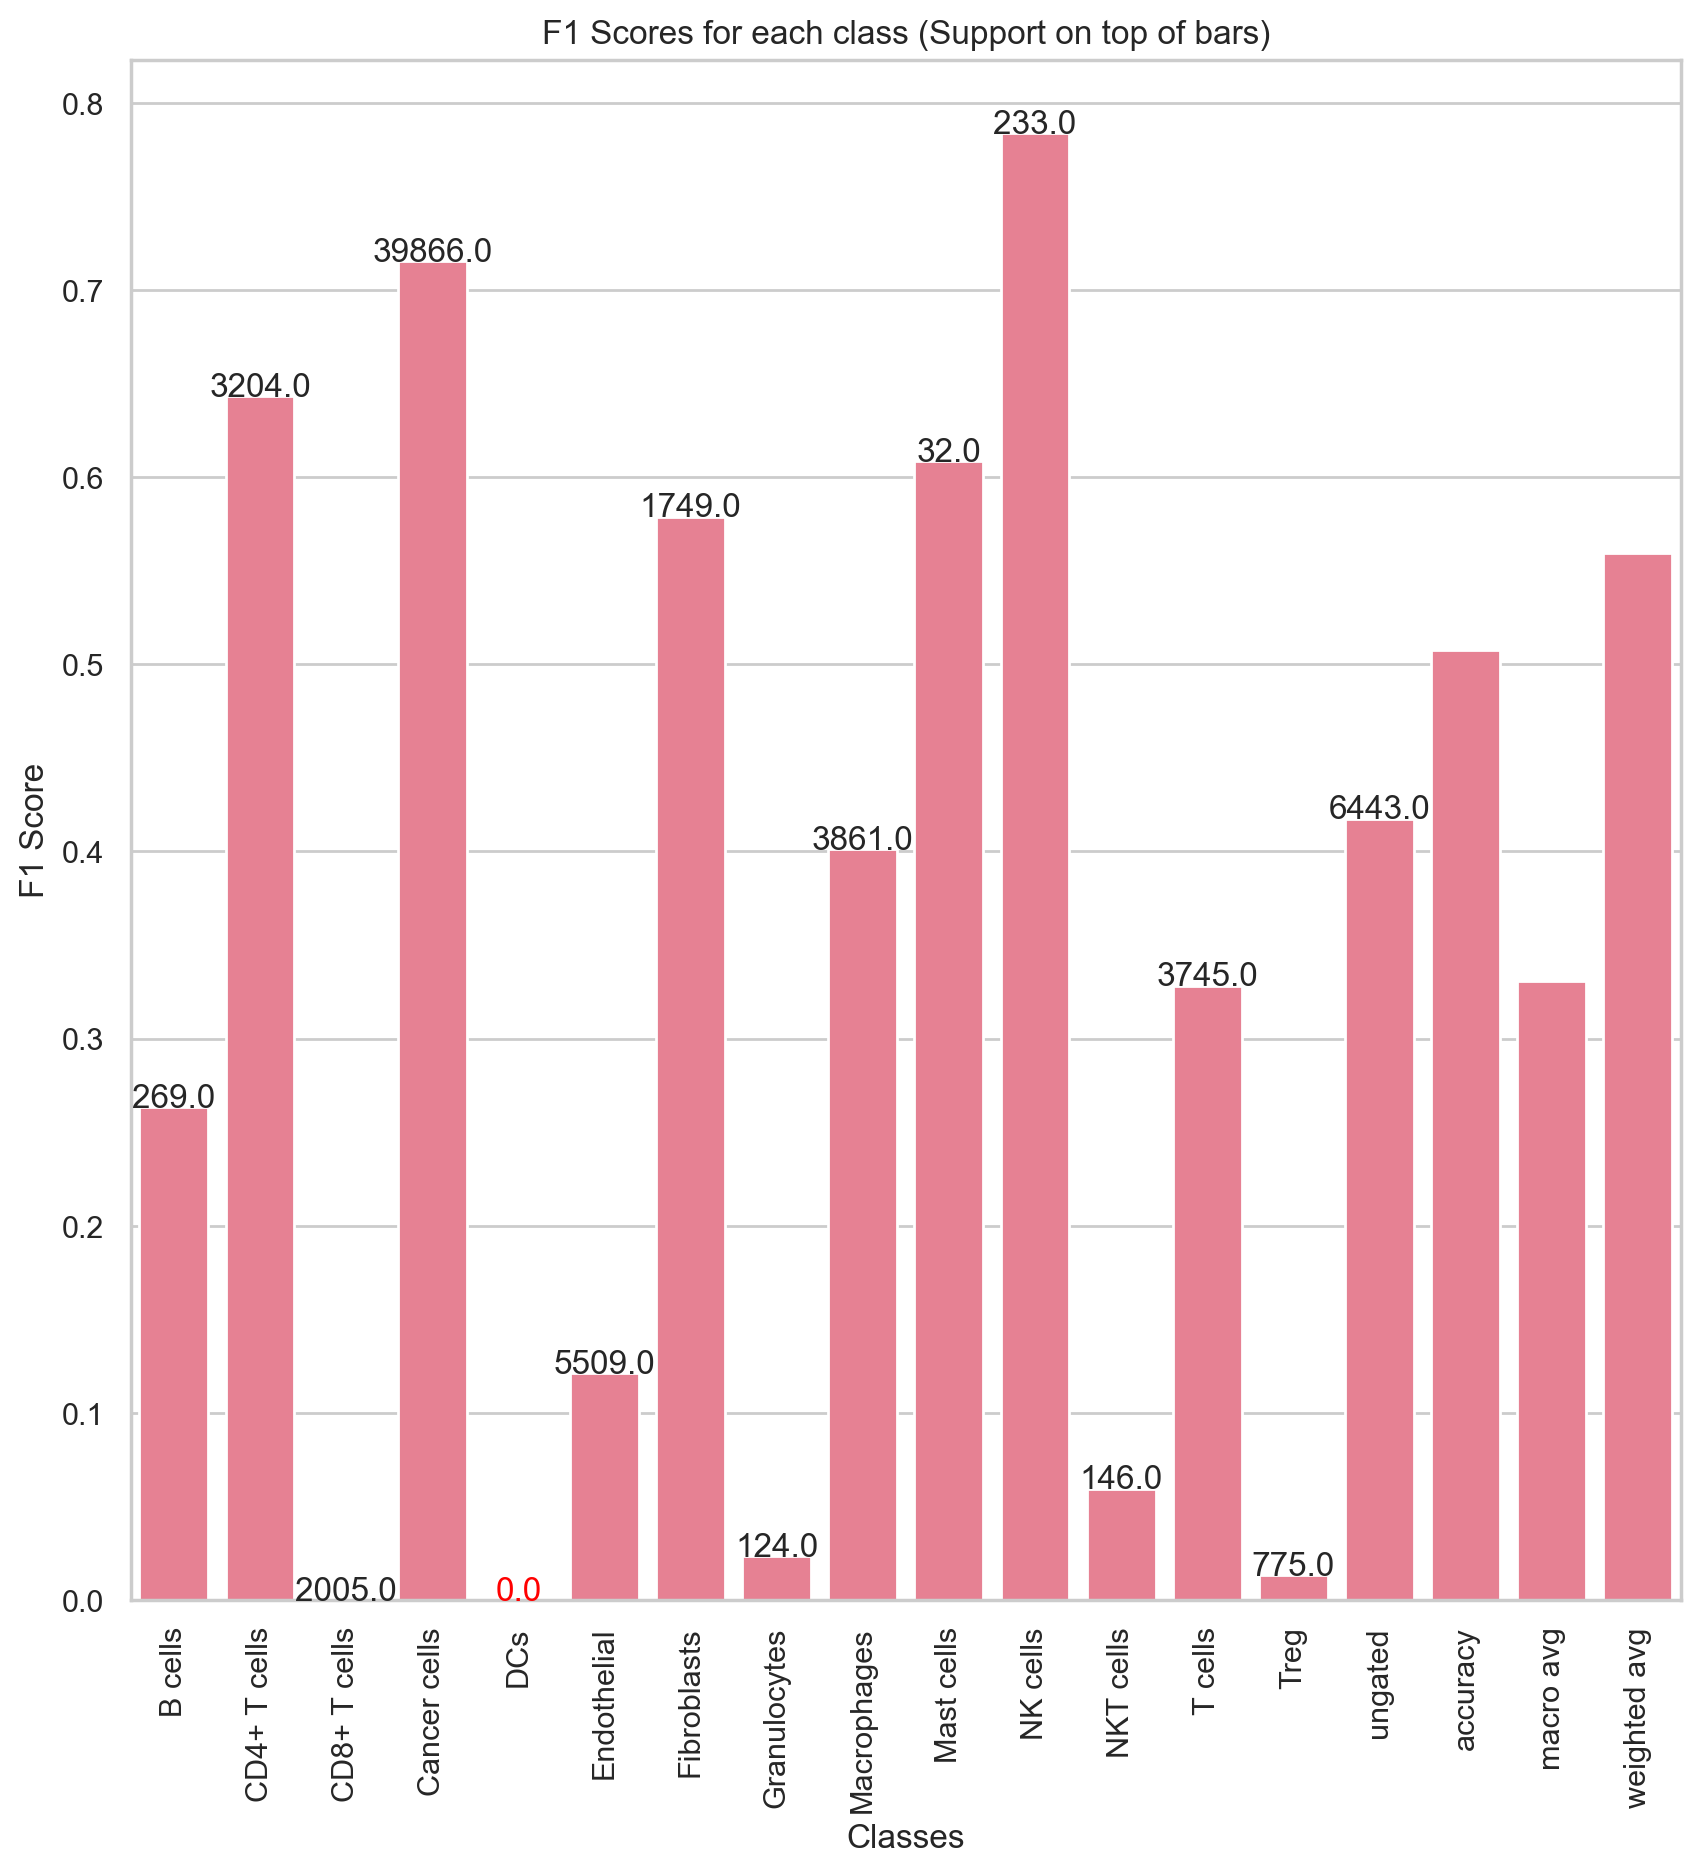

In [24]:
# Plot a bar-plot for tthe F1 scores and the cell types
plt.figure(figsize=(10, 10))
sns.set(style="whitegrid")
sns.set_palette("husl")
sns.barplot(y='f1-score', x='index', data=df_f1_scores)
plt.title('F1 Scores for each class (Support on top of bars)')
plt.ylabel('F1 Score')
plt.xlabel('Classes')
plt.xticks(rotation=90)

#plot the support on top of bars except for the last 3 bars and color the text red if the support is less than 10
for i in range(len(df_f1_scores)-3):
    if df_f1_scores['support'][i] < 10:
        plt.text(i, df_f1_scores['f1-score'][i], df_f1_scores['support'][i], ha = 'center', color='red')
    else:
        plt.text(i, df_f1_scores['f1-score'][i], df_f1_scores['support'][i], ha = 'center')

plt.show()

# Save the figure